In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image

In [ ]:
classes = ['class_0','class_1', 'test_class_0', 'test_class_1']
class_1_speakers = ['f1','f7','f8','m3','m6','m8']
basePath = 'daps'
filepaths = [
    "cleanraw",
    "ipad_balcony1",
    "ipad_bedroom1",
    "ipad_confroom1",
    "ipad_confroom2",
    "ipadflat_confroom1",
    "ipadflat_office1",
    "ipad_livingroom1",
    "ipad_office1",
    "ipad_office2",
    "iphone_balcony1",
    "iphone_bedroom1",
    "iphone_livingroom1",
    ]
sample_rate = 44100 # Obtained from the EDA
os.makedirs('spectrograms', exist_ok=True)
for cl in classes:
    os.makedirs(os.path.join('spectrograms',cl),exist_ok=True)

In [ ]:
import audio_utils
audio_utils.load_audio_files(basePath=basePath, filepaths=filepaths, class_1_speakers=class_1_speakers, name="script5", sample_rate=sample_rate)

In [ ]:
def process_classes():
    spectrograms = {
        'class_0': audio_utils.generate_spectrograms(audio=audio, class_label='class_0', sample_rate=sample_rate),
        'class_1': audio_utils.generate_spectrograms(audio=audio, class_label='class_1', sample_rate=sample_rate),
        'test_class_0': audio_utils.generate_spectrograms(audio=audio, class_label='test_class_0', sample_rate=sample_rate),
        'test_class_1': audio_utils.generate_spectrograms(audio=audio, class_label='test_class_1', sample_rate=sample_rate)
    }

    for class_label in classes:
        i = 0
        for spectrogram in tqdm(spectrograms[class_label], desc=f'Processing {class_label}'):
            plt.figure(figsize=(2, 2))
            librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
            # plt.colorbar(format='%+2.0f dB')
            # plt.title(class_label)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join('spectrograms', class_label, f'{class_label}_{i+1}.png'), bbox_inches='tight', pad_inches=0)
            plt.close()
            i+=1
            # plt.show()


In [ ]:
process_classes()

In [23]:
print("class_0 images:",len(os.listdir('spectrograms/train/class_0')))
print("class_1 images:", len(os.listdir('spectrograms/train/class_1')))
print("test_class_0 images:", len(os.listdir('spectrograms/test/class_0')))
print("test_class_1 images:", len(os.listdir('spectrograms/test/class_1')))

class_0 images: 22054
class_1 images: 19861
test_class_0 images: 5291
test_class_1 images: 4881


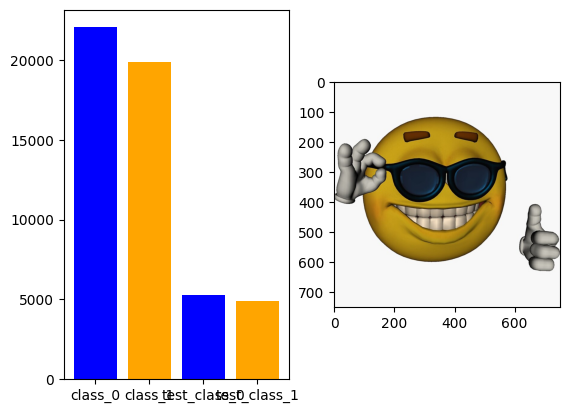

In [25]:
img = Image.open('ok.jpg')
plt.subplot(1,2,1)
plt.bar(x=classes,height=[len(os.listdir('spectrograms/train/class_0')),len(os.listdir('spectrograms/train/class_1')), len(os.listdir('spectrograms/test/class_0')), len(os.listdir('spectrograms/test/class_1'))],color=['blue','orange'])
plt.subplot(1,2,2)
plt.imshow(img)
plt.show()

### Now classes are git balans

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

batch_size = 4

train_dataset = torchvision.datasets.ImageFolder(root='spectrograms/train', transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_mean = torch.stack([img.mean(1).mean(1) for img, _ in train_dataset]).mean(0)
train_std = torch.stack([img.std(1).std(1) for img, _ in train_dataset]).mean(0)

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = torchvision.datasets.ImageFolder("spectrograms/train", transform=data_transforms)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8,0.2])

test_dataset = torchvision.datasets.ImageFolder("spectrograms/test", transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_mean = torch.stack([img.mean(1).mean(1) for img, _ in test_dataset]).mean(0)
test_std = torch.stack([img.std(1).std(1) for img, _ in test_dataset]).mean(0)

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std)
])

test_dataset = torchvision.datasets.ImageFolder("spectrograms/test", transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_std, train_mean)

In [ ]:
def imshow(img, mean, std):
    # Unnormalize
    img = img.clone() 
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i] 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), train_mean, train_std)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

In [ ]:
net.to(device)

In [ ]:
import wandb
from model_params import params

wandb.init(project="Voice-Recognition", config={
    "learning_rate": params['learning_rate'],
    "epochs": params['epochs'],
})


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["learning_rate"], momentum=params["momentum"])

In [ ]:
for epoch in range(params["epochs"]):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            wandb.log({"validation_loss": loss.item(), "validation_acc": correct / total})
    

print('Finished Training')

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
imshow(torchvision.utils.make_grid(images), test_mean, test_std)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
images, labels = images.to(device), labels.to(device)

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wandb.log({"test_loss": loss.item(), "test_acc": correct / total})

print(f'Accuracy of the network: {100 * correct // total} %')

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
import sklearn.metrics as skm
import seaborn as sns
# Evaluation on test set with F1 score and confusion matrix
net.eval()
all_labels = []
all_predictions = []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Track total and correct for accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append results for F1 score and confusion matrix calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = 100 * correct / total
f1 = skm.f1_score(y_true=all_labels, y_pred=all_predictions,average='macro')
conf_matrix = skm.confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}")


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(net.state_dict(),'model_1.pth')